In [1]:
!pip -qq install split-folders tqdm xgboost

In [65]:
import os
import glob
import cv2
import splitfolders
import torch
import torchvision
import time
import copy
import random
import shutil
import tqdm
import itertools
import xgboost

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 12)

from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    silhouette_score,
    accuracy_score
)

from hyperopt import (STATUS_OK, 
                      Trials, 
                      fmin, 
                      hp, 
                      tpe)

from torchvision.transforms import (
    Compose,
    Lambda,
    Normalize,
    AutoAugment,
    AutoAugmentPolicy,
    Resize,
    ToTensor,
)

# Tested on torch==1.11.0, torchvision==0.12.0
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


# Data analysis

In [3]:
data_samples = glob.glob("/kaggle/input/bj-demo/images/*/*.jpg")
dataset_df = pd.DataFrame({"sample_path": data_samples})
dataset_df["label"] = dataset_df["sample_path"].apply(lambda x: x.split("/")[5])

## Problem 1: The dataset is imbalanced

In [4]:
dataset_df["label_id"] = dataset_df.groupby("label").ngroup()
dataset_df["label_id"].describe()

count    1422.000000
mean        3.047820
std         2.031897
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: label_id, dtype: float64

In [5]:
dataset_df["label"].value_counts()

Cubism           365
Impressionism    240
Naturalism       218
Japonism         203
photo            139
Rococo           117
cartoon           75
ArtDeco           65
Name: label, dtype: int64

## Problem 2: There may be outliers

In [6]:
tmp = dataset_df[
    dataset_df["sample_path"] == 
    "/kaggle/input/bj-demo/images/Cubism/charles-sheeler_still-life-1925.jpg"
]

In [7]:
tmp_image = cv2.imread(tmp.iloc[0]["sample_path"])
tmp_image = cv2.cvtColor(tmp_image, cv2.COLOR_BGR2RGB)

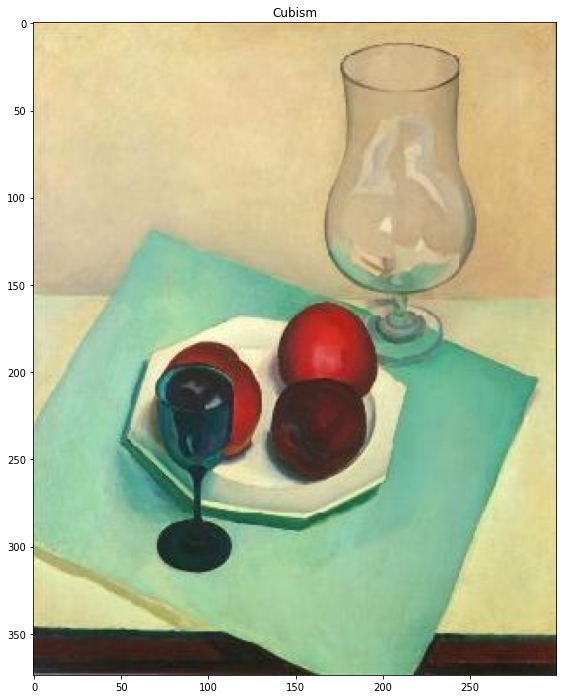

In [8]:
plt.imshow(tmp_image)
plt.title(tmp.iloc[0]["label"])
plt.show()

But it is probably precisionism: see [link](https://www.wikiart.org/en/charles-sheeler/still-life-1925)

Note that it is difficult to detect outliers without advanced knowlege in art.

## Solution #1
CNN + Boosting

Motivation: [The Image Classification Method with CNN-XGBoost Model Based on Adaptive Particle Swarm Optimization](https://www.researchgate.net/publication/350779605_The_Image_Classification_Method_with_CNN-XGBoost_Model_Based_on_Adaptive_Particle_Swarm_Optimization)

TLDR: Classic CNN models are well known as great feature extractors, however their classification layer is strongly affected by noise and class imbalance. The article presents a modified classifier based on feature extractor and XGBoost classifier.

We still need to deal with class imbalance.

### Idea #1: oversampling + augmentations

[Source](https://medium.com/analytics-vidhya/handling-imbalanced-dataset-in-image-classification-dc6f1e13aeee#:~:text=Oversampling%20means%20that%20we%20increase,it%20thus%20get%20more%20balanced.)

We need to split dataset into train/val/test subsets. As validation and test subsets do not suppose augmentations, we perform oversampling only with train. The dataset is considerably small, so undersampling will probably decrease overall quality.

In [9]:
!mkdir /kaggle/temp

In [10]:
!rm -R /kaggle/temp/*

rm: cannot remove '/kaggle/temp/*': No such file or directory


In [11]:
# Initially we generate test subset with class balance (8 for each class)
splitfolders.fixed(
    "../input/bj-demo/images",
    output="/kaggle/temp/trainval_test",
    oversample=False,
    seed=42,
    fixed=8,
    group_prefix=None,
)    

!mv /kaggle/temp/trainval_test/val /kaggle/temp/test
!mv /kaggle/temp/trainval_test/train /kaggle/temp/trainval
!rm -R /kaggle/temp/trainval_test

Copying files: 1422 files [00:09, 145.59 files/s]


In [12]:
# Then we split into tran/val subsets. Validation subset is balanced as well as test.
# The train subset is balanced with oversampling 
# i.e. making copies of images until the required number of samples is reached.
splitfolders.fixed(
    "/kaggle/temp/trainval",
    output="/kaggle/temp/train_val",
    oversample=True,
    seed=42,
    fixed=16,
    group_prefix=None,
    move=False,
)  # default values
!mv /kaggle/temp/train_val/train /kaggle/temp/train
!mv /kaggle/temp/train_val/val /kaggle/temp/val
!rm -R /kaggle/temp/train_val
!rm -R /kaggle/temp/trainval

Copying files: 1358 files [00:00, 5303.55 files/s]
Oversampling: 8 classes [00:00, 28.32 classes/s]


As dataset is small we don't train from scratch. We use pretrained on imagenet model as it is quite close to task domain. Considering the nest steps, it is reasonable to use fine-tuning strategy. (Transfer learning will keep feature extractor still).

In [13]:
data = "/kaggle/temp/"
num_classes = len(os.listdir(data + "/train"))
num_epochs = 10
img_size = 299
batch_size = 16

In [14]:
# representability
seed = 42
print(f"setting everything to seed {seed}")
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


In [15]:
data_transforms = {
    "train": Compose(
        [
            Resize((img_size, img_size)),
            AutoAugment(AutoAugmentPolicy.IMAGENET),
            ToTensor(),
            Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    ),
    "val": Compose(
        [
            Resize((img_size, img_size)),
            ToTensor(),
            Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    ),
}

In [16]:
image_datasets = {
    x: torchvision.datasets.ImageFolder(os.path.join(data, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders_dict = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2
    )
    for x in ["train", "val"]
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
LABEL_TO_CLASSNUM = image_datasets["train"].find_classes("/kaggle/temp/train")[1]
CLASSNUM_TO_LABEL = {v: k for k, v in LABEL_TO_CLASSNUM.items()}

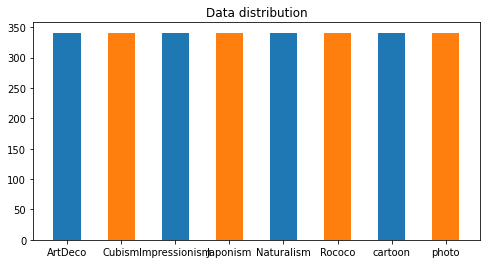

In [18]:
def plot_data_distribution(dataset):
    
    # Ensure our datasets have class balance
    labels = dataset.targets
    _, labels_count = np.unique(labels, return_counts=True)

    class_names = dataset.classes

    plt.figure(figsize=(8, 4))
    plt.title("Data distribution")
    plt.bar(class_names, labels_count, width=0.5, color=["C0", "C1"])
    plt.show()


plot_data_distribution(image_datasets["train"])

In [19]:
def initialize_model(num_classes, use_pretrained=True):

    # On small datasets complex models are more likely to overfit
    model = torchvision.models.resnet18(pretrained=use_pretrained)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)

    return model

model = initialize_model(num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

As we have "balanced" dataset now, we can use classic accuracy and loss function

In [21]:
criterion = torch.nn.CrossEntropyLoss()

In [22]:
def train_model(
    model, dataloaders, optimizer, criterion=criterion, num_epochs=num_epochs
):

    start = time.time()
    metrics = {"train": {"loss": [], "acc": []}, "val": {"loss": [], "acc": []}}
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        for phase in ["train", "val"]:
            running_loss = 0
            running_corrects = 0
            if phase == "train":
                model.train()
            else:
                model.eval()
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # Backward pass and Optimization in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            metrics[phase]["loss"].append(epoch_loss)
            metrics[phase]["acc"].append(epoch_acc.item())
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time()
    model.load_state_dict(best_model_weights)
    
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))
    return model, metrics


In [23]:
model, history = train_model(model, dataloaders_dict, optimizer, criterion, num_epochs)

Epoch 0/9


100%|██████████| 171/171 [00:30<00:00,  5.52it/s]


train Loss: 1.4902 Acc: 0.5187


100%|██████████| 8/8 [00:01<00:00,  7.90it/s]


val Loss: 0.9280 Acc: 0.7734
Epoch 1/9


100%|██████████| 171/171 [00:23<00:00,  7.18it/s]


train Loss: 0.8233 Acc: 0.7581


100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


val Loss: 0.6931 Acc: 0.8125
Epoch 2/9


100%|██████████| 171/171 [00:23<00:00,  7.17it/s]


train Loss: 0.5916 Acc: 0.8120


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


val Loss: 0.6152 Acc: 0.8047
Epoch 3/9


100%|██████████| 171/171 [00:24<00:00,  7.05it/s]


train Loss: 0.4502 Acc: 0.8699


100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


val Loss: 0.6156 Acc: 0.8281
Epoch 4/9


100%|██████████| 171/171 [00:23<00:00,  7.16it/s]


train Loss: 0.3585 Acc: 0.8955


100%|██████████| 8/8 [00:00<00:00,  8.22it/s]


val Loss: 0.6143 Acc: 0.7969
Epoch 5/9


100%|██████████| 171/171 [00:24<00:00,  7.01it/s]


train Loss: 0.3093 Acc: 0.9073


100%|██████████| 8/8 [00:00<00:00,  8.08it/s]


val Loss: 0.5750 Acc: 0.8359
Epoch 6/9


100%|██████████| 171/171 [00:24<00:00,  6.86it/s]


train Loss: 0.2464 Acc: 0.9318


100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


val Loss: 0.6136 Acc: 0.8203
Epoch 7/9


100%|██████████| 171/171 [00:24<00:00,  7.09it/s]


train Loss: 0.2281 Acc: 0.9373


100%|██████████| 8/8 [00:00<00:00,  8.06it/s]


val Loss: 0.6359 Acc: 0.7969
Epoch 8/9


100%|██████████| 171/171 [00:24<00:00,  7.04it/s]


train Loss: 0.1932 Acc: 0.9428


100%|██████████| 8/8 [00:00<00:00,  8.37it/s]


val Loss: 0.6673 Acc: 0.7891
Epoch 9/9


100%|██████████| 171/171 [00:24<00:00,  6.96it/s]


train Loss: 0.1754 Acc: 0.9512


100%|██████████| 8/8 [00:01<00:00,  6.00it/s]

val Loss: 0.6262 Acc: 0.8047
Training complete in 27785557m 8s
Best val Acc: 0.835938


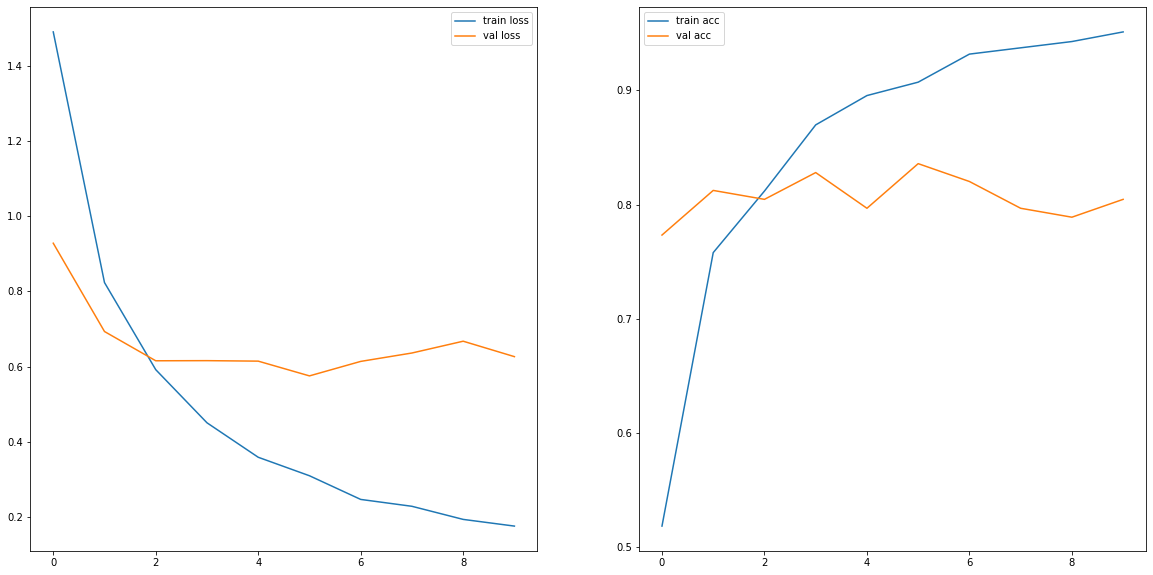

In [24]:
def make_plots(history) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.plot(history["train"]["loss"], label="train loss")
    ax1.plot(history["val"]["loss"], label="val loss")
    ax1.legend()

    ax2.plot(history["train"]["acc"], label="train acc")
    ax2.plot(history["val"]["acc"], label="val acc")
    ax2.legend()

    plt.show()


make_plots(history)

The plost demonstrate overfitting (probably to oversampled classes)

In [25]:
def predict(in_path):
    
    in_image = cv2.imread(in_path)
    with torch.no_grad():
        in_image = torch.tensor(cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)).to(device)
        in_image = in_image.permute(2,0,1)
        in_image = torch.unsqueeze(in_image, 0)
        in_image = in_image.float() / 255.
        prediction = model(in_image)
        prob = F.softmax(prediction, dim=1).detach().cpu().numpy()
        _, pred = torch.max(prediction, dim=1)
        
    return (pred.item(), prob.tolist())

In [26]:
model.eval()
model = model.to()
test_files = glob.glob("/kaggle/temp/test/*/*.jpg")

In [27]:
y_true = []
y_pred = []
y_prob = []
for test_file in tqdm.tqdm(test_files):
    label = test_file.split("/")[-2]
    pred = predict(test_file)
    y_true.append(LABEL_TO_CLASSNUM[label])
    y_pred.append(pred[0])
    y_prob.append(pred[1][0])

100%|██████████| 64/64 [00:00<00:00, 96.81it/s]


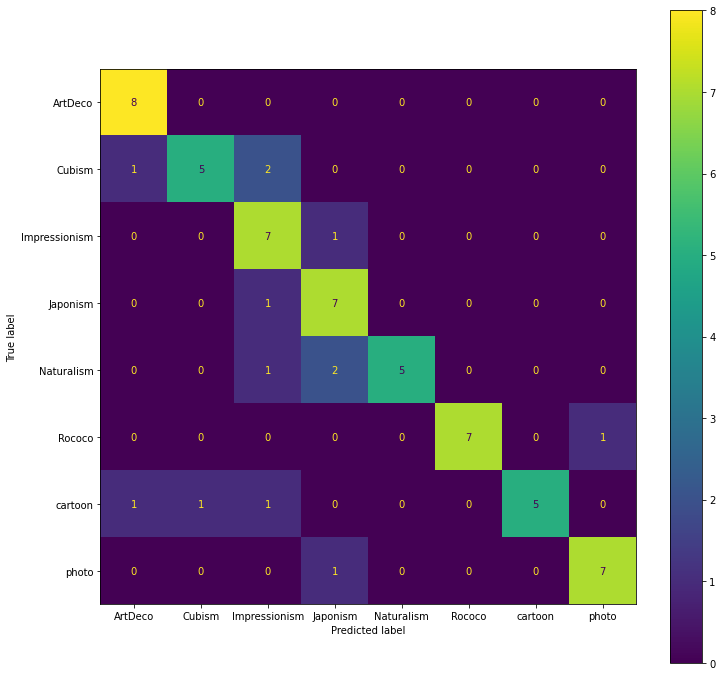

               precision    recall  f1-score   support

      ArtDeco       0.80      1.00      0.89         8
       Cubism       0.83      0.62      0.71         8
Impressionism       0.58      0.88      0.70         8
     Japonism       0.64      0.88      0.74         8
   Naturalism       1.00      0.62      0.77         8
       Rococo       1.00      0.88      0.93         8
      cartoon       1.00      0.62      0.77         8
        photo       0.88      0.88      0.88         8

     accuracy                           0.80        64
    macro avg       0.84      0.80      0.80        64
 weighted avg       0.84      0.80      0.80        64



In [28]:
def get_accuracy(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=CLASSNUM_TO_LABEL.values()
    )
    disp.plot()
    plt.show()

    print(
        classification_report(
            y_true,
            y_pred,
            labels=list(CLASSNUM_TO_LABEL.keys()),
            target_names=list(CLASSNUM_TO_LABEL.values()),
        )
    )
get_accuracy(y_true, y_pred)

In [29]:
torch.save(model.state_dict(), "/kaggle/working/classifier_oversampling.pt")

### Idea #2: loss with weights

In [30]:
!rm -R /kaggle/temp/*

In [31]:
# Create balanced test and val subsets and imbalanced train subset
splitfolders.fixed(
    "../input/bj-demo/images",
    output="/kaggle/temp/trainval_test",
    oversample=False,
    seed=42,
    fixed=8,
    group_prefix=None,
    move=False,
)

!mv /kaggle/temp/trainval_test/val /kaggle/temp/test
!mv /kaggle/temp/trainval_test/train /kaggle/temp/trainval
!rm -R /kaggle/temp/trainval_test

splitfolders.fixed(
    "/kaggle/temp/trainval",
    output="/kaggle/temp/train_val",
    oversample=False,
    seed=42,
    fixed=16,
    group_prefix=None,
    move=False,
)

!mv /kaggle/temp/train_val/train /kaggle/temp/train
!mv /kaggle/temp/train_val/val /kaggle/temp/val
!rm -R /kaggle/temp/train_val
!rm -R /kaggle/temp/trainval

Copying files: 1422 files [00:01, 1020.59 files/s]
Copying files: 1358 files [00:00, 5249.68 files/s]


In [32]:
image_datasets = {
    x: torchvision.datasets.ImageFolder(os.path.join(data, x), data_transforms[x])
    for x in ["train", "val"]
}

dataloaders_dict = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2
    )
    for x in ["train", "val"]
}

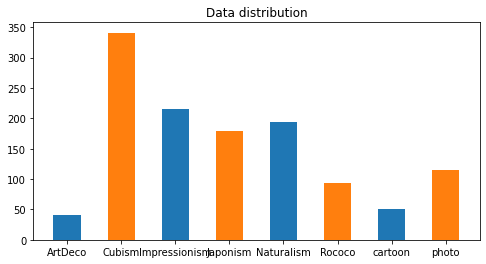

In [33]:
plot_data_distribution(image_datasets["train"])

In [34]:
# Generate label weights
labels = image_datasets["train"].targets
_, labels_count = np.unique(labels, return_counts=True)
label_weights = torch.Tensor(
    [1 - (x / len(image_datasets["train"])) for x in labels_count]
).to(device)
label_weights

tensor([0.9667, 0.7228, 0.8244, 0.8545, 0.8423, 0.9244, 0.9585, 0.9065],
       device='cuda:0')

[source](https://naadispeaks.wordpress.com/2021/07/31/handling-imbalanced-classes-with-weighted-loss-in-pytorch/)

In [35]:
model = initialize_model(num_classes)
model = model.to(device)

In [36]:
criterion = torch.nn.CrossEntropyLoss(label_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

In [37]:
model, history = train_model(model, dataloaders_dict, optimizer, criterion, num_epochs)

Epoch 0/9


100%|██████████| 77/77 [00:11<00:00,  6.58it/s]


train Loss: 1.6797 Acc: 0.4350


100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


val Loss: 1.6416 Acc: 0.5078
Epoch 1/9


100%|██████████| 77/77 [00:10<00:00,  7.12it/s]


train Loss: 1.1905 Acc: 0.6341


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


val Loss: 1.2215 Acc: 0.6172
Epoch 2/9


100%|██████████| 77/77 [00:11<00:00,  6.97it/s]


train Loss: 0.9639 Acc: 0.7057


100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


val Loss: 1.0196 Acc: 0.6641
Epoch 3/9


100%|██████████| 77/77 [00:11<00:00,  6.93it/s]


train Loss: 0.8236 Acc: 0.7366


100%|██████████| 8/8 [00:00<00:00,  8.49it/s]


val Loss: 0.8216 Acc: 0.7578
Epoch 4/9


100%|██████████| 77/77 [00:10<00:00,  7.10it/s]


train Loss: 0.7071 Acc: 0.7902


100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


val Loss: 0.7800 Acc: 0.7578
Epoch 5/9


100%|██████████| 77/77 [00:11<00:00,  6.71it/s]


train Loss: 0.6399 Acc: 0.8033


100%|██████████| 8/8 [00:00<00:00,  8.22it/s]


val Loss: 0.6776 Acc: 0.7812
Epoch 6/9


100%|██████████| 77/77 [00:11<00:00,  6.91it/s]


train Loss: 0.5951 Acc: 0.8130


100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


val Loss: 0.6755 Acc: 0.7422
Epoch 7/9


100%|██████████| 77/77 [00:10<00:00,  7.07it/s]


train Loss: 0.5104 Acc: 0.8325


100%|██████████| 8/8 [00:01<00:00,  6.10it/s]


val Loss: 0.6362 Acc: 0.7734
Epoch 8/9


100%|██████████| 77/77 [00:11<00:00,  6.43it/s]


train Loss: 0.4682 Acc: 0.8585


100%|██████████| 8/8 [00:01<00:00,  7.91it/s]


val Loss: 0.5814 Acc: 0.7969
Epoch 9/9


100%|██████████| 77/77 [00:10<00:00,  7.11it/s]


train Loss: 0.4346 Acc: 0.8675


100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

val Loss: 0.6035 Acc: 0.7969
Training complete in 27785559m 23s
Best val Acc: 0.796875


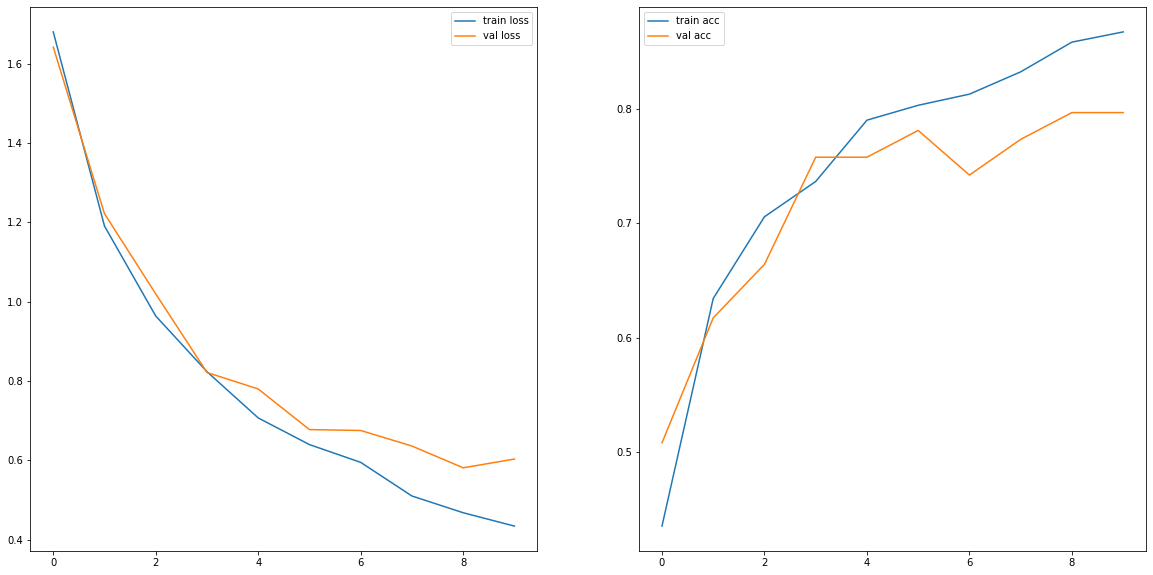

In [38]:
make_plots(history)

In [39]:
model.eval()
model = model.to()
test_files = glob.glob("/kaggle/temp/test/*/*.jpg")

In [40]:
y_true = []
y_pred = []
y_prob = []
for test_file in tqdm.tqdm(test_files):
    label = test_file.split("/")[-2]
    pred = predict(test_file)
    y_true.append(LABEL_TO_CLASSNUM[label])
    y_pred.append(pred[0])
    y_prob.append(pred[1][0])

100%|██████████| 64/64 [00:00<00:00, 99.24it/s] 


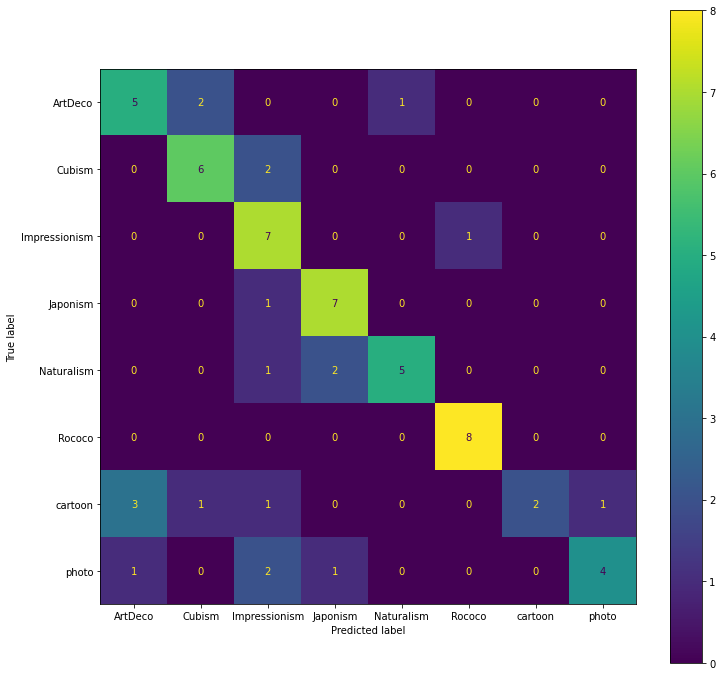

               precision    recall  f1-score   support

      ArtDeco       0.56      0.62      0.59         8
       Cubism       0.67      0.75      0.71         8
Impressionism       0.50      0.88      0.64         8
     Japonism       0.70      0.88      0.78         8
   Naturalism       0.83      0.62      0.71         8
       Rococo       0.89      1.00      0.94         8
      cartoon       1.00      0.25      0.40         8
        photo       0.80      0.50      0.62         8

     accuracy                           0.69        64
    macro avg       0.74      0.69      0.67        64
 weighted avg       0.74      0.69      0.67        64



In [41]:
get_accuracy(y_true, y_pred)

In [42]:
torch.save(model.state_dict(), "/kaggle/working/classifier_weights.pt")

As we see, the oversampling strategy works better. This may be due to strong augmentations. 

However in some situations weights may be better. It depends on context

# Task 2

Here we generate embeddings and try to asess how good the classes are separated.

Another option is to try to cluster the embeddings and distinguish the outliers (see data analysis).

In [43]:
embedding_paths = glob.glob("/kaggle/input/bj-demo/images/*/*.jpg")

In [139]:
def initialize_feat_extractor(num_classes, imagenet_pretrained=False):
    model = torchvision.models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)
    if not imagenet_pretrained:
        state_dict = torch.load(
            "/kaggle/working/classifier_oversampling.pt",
            map_location=torch.device("cpu"),
        )
        model.load_state_dict(state_dict)
    extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
    extractor.eval()
    extractor = extractor.to(device)
    return extractor


def get_feature(model, in_path):
    in_image = cv2.imread(in_path)
    with torch.no_grad():
        in_image = torch.tensor(cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)).to(device)
        in_image = in_image.permute(2, 0, 1)
        in_image = torch.unsqueeze(in_image, 0)
        in_image = in_image.float() / 255.0
        prediction = model(in_image)
    return torch.flatten(prediction).cpu().numpy()


May be we did not need training above? 

The model, pretrained on imagenet, may give good results.

In [140]:
num_classes = len(os.listdir("/kaggle/input/bj-demo/images"))
pretrained_extractor = initialize_feat_extractor(num_classes)
imagenet_extractor = initialize_feat_extractor(num_classes, imagenet_pretrained=True)

In [141]:
pretrained_embeddings = []
for emb_path in tqdm.tqdm(embedding_paths):
    pretrained_embeddings.append(get_feature(pretrained_extractor, emb_path))

100%|██████████| 1422/1422 [00:16<00:00, 88.62it/s]


In [142]:
imagenet_embeddings = []
for emb_path in tqdm.tqdm(embedding_paths):
    imagenet_embeddings.append(get_feature(imagenet_extractor, emb_path))

100%|██████████| 1422/1422 [00:15<00:00, 89.92it/s]


In [143]:
embeddings_df = pd.DataFrame(
    {
        "paths": embedding_paths,
        "pretrained_embeddings": pretrained_embeddings,
        "imagenet_embeddings": imagenet_embeddings,
    }
)

In [144]:
pretrained_embeddings_norm = normalize(pretrained_embeddings, norm='l2').tolist()
embeddings_df["pretrained_embeddings_norm"] = [np.array(x) for x in pretrained_embeddings_norm]

In [145]:
imagenet_embeddings_norm = normalize(imagenet_embeddings, norm='l2').tolist()
embeddings_df["imagenet_embeddings_norm"] = [np.array(x) for x in imagenet_embeddings_norm]

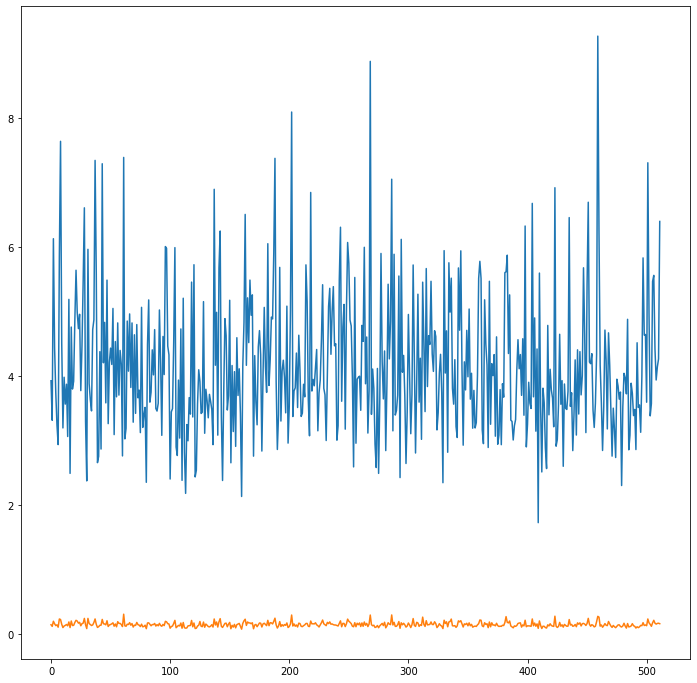

In [146]:
plt.plot(np.max(np.array(pretrained_embeddings), axis=0))
plt.plot(np.max(pretrained_embeddings_norm, axis=0))
plt.show()

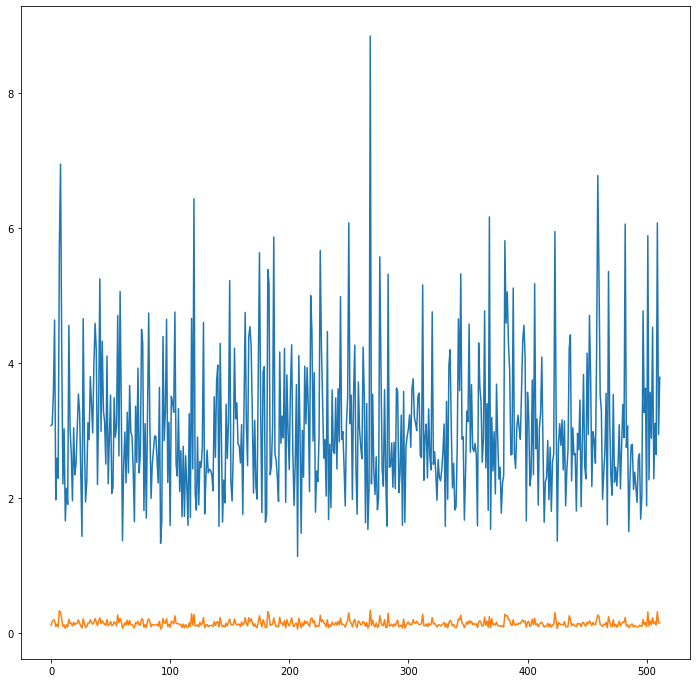

In [147]:
plt.plot(np.max(np.array(imagenet_embeddings), axis=0))
plt.plot(np.max(imagenet_embeddings_norm, axis=0))
plt.show()

In [148]:
# Get nice projection of embeddings into 2d-space
pretrained_embeddings_2d = TSNE(
    n_components=2, learning_rate="auto", init="random"
).fit_transform(np.array(pretrained_embeddings_norm))
imagenet_embeddings_2d = TSNE(
    n_components=2, learning_rate="auto", init="random"
).fit_transform(np.array(imagenet_embeddings_norm))

In [149]:
embeddings_df["pretrained_embeddings_2d"] = pretrained_embeddings_2d.tolist()
embeddings_df["imagenet_embeddings_2d"] = imagenet_embeddings_2d.tolist()
embeddings_df["gt_label"] = embeddings_df["paths"].apply(lambda x: x.split("/")[5])

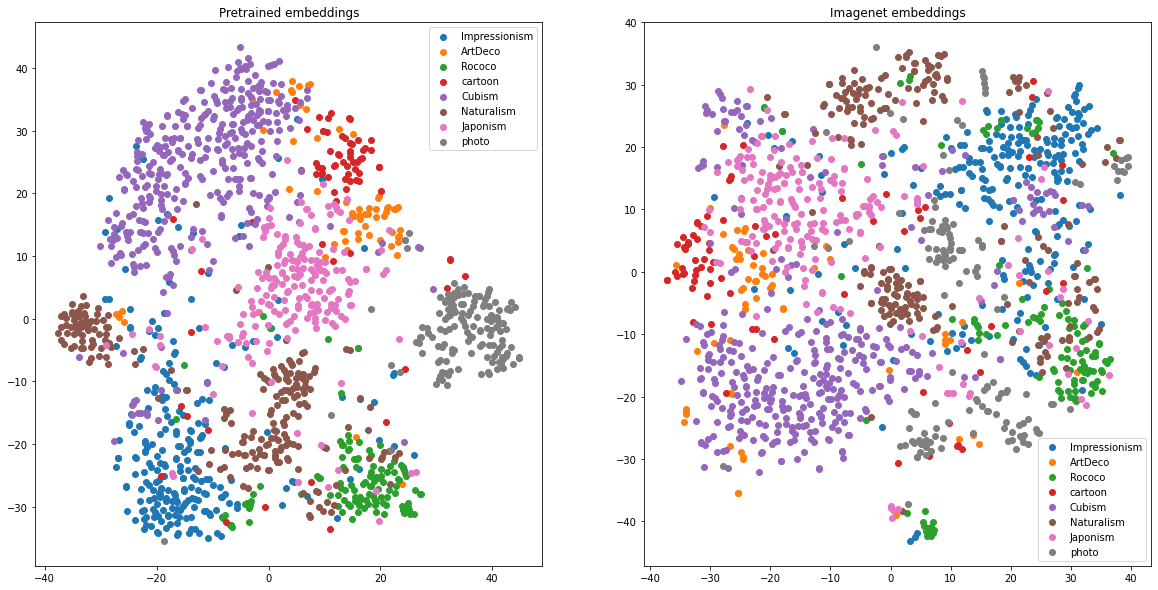

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    ax1.scatter(
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
ax1.set_title("Pretrained embeddings")
ax1.legend()

for i in u_labels:
    ax2.scatter(
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i][
                "imagenet_embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i][
                "imagenet_embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
ax2.set_title("Imagenet embeddings")
ax2.legend()

plt.show()

Pretrained embedding are obviously better. 

However, if there was no gpu or labeling, the clusterization problem still could have been solved

(at least for some labels)

To asess the cluster quality we will use the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

The score is calculated between two sets. Here we will find the score between every pair of classes.

! one-vs-all may be bad if the cluster is surrounded by others.

In [151]:
# here add silhouette
embeddings_df["gt_labelnum"] = embeddings_df["gt_label"].apply(
    lambda x: LABEL_TO_CLASSNUM[x]
)


In [152]:
def calc_silhouette(classA: int, classB: int, df: pd.DataFrame, key: str) -> float:
    classA_df = embeddings_df[embeddings_df["gt_labelnum"] == classA]
    classB_df = embeddings_df[embeddings_df["gt_labelnum"] == classB]
    combined_df = pd.concat([classA_df, classB_df])
    return silhouette_score(
        combined_df[key].tolist(), combined_df["gt_labelnum"].tolist()
    )

In [154]:
combinations_list = list(
    itertools.combinations(list(embeddings_df["gt_labelnum"].unique()), 2)
)

sihlouette_dict = {
    "classes_A": [],
    "classes_B": [],
    "silhouette_pretrained": [],
    "sihlouette_imagenet": [],
}

for item in combinations_list:
    sihlouette_dict["classes_A"].append(item[0])
    sihlouette_dict["classes_B"].append(item[1])
    sihlouette_dict["silhouette_pretrained"].append(
        calc_silhouette(item[0], item[1], embeddings_df, key="pretrained_embeddings_norm")
    )
    sihlouette_dict["sihlouette_imagenet"].append(
        calc_silhouette(item[0], item[1], embeddings_df, key="imagenet_embeddings_norm")
    )
silhouette_df = pd.DataFrame(sihlouette_dict)

In [155]:
silhouette_df

,classes_A,classes_B,silhouette_pretrained,sihlouette_imagenet
0,2,0,0.206112,0.144798
1,2,5,0.123578,0.081680
2,2,6,0.181036,0.135017
3,2,1,0.171089,0.096286
4,2,4,0.085623,0.052554
5,2,3,0.136367,0.085653
6,2,7,0.197478,0.101935
7,0,5,0.181742,0.106247
8,0,6,0.081210,0.028013
9,0,1,0.082976,0.051102


It would be nice to remove dataset noise. One solution is to use OPTICS algorithm.

I have tried to cluster embeddings with OPTICS, but surprisingly did not achieve good result. The problem may be in [curse of dimensionality](https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb).

Lets check the clusterization result

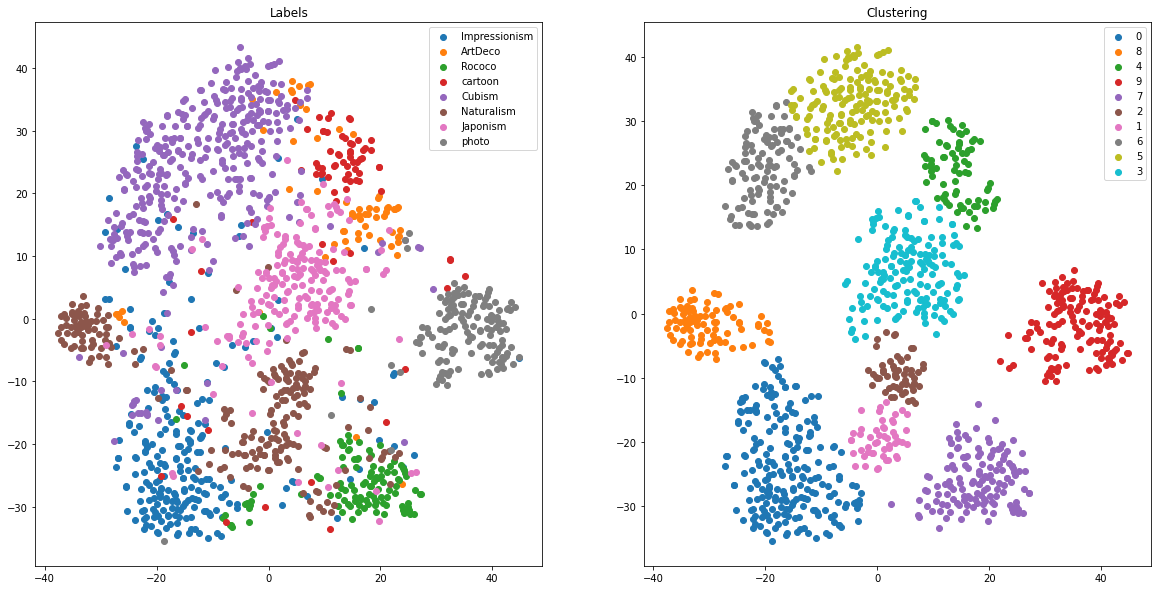

In [177]:
clusters = OPTICS(min_samples=37, xi=0.0001)
clusters.fit(pretrained_embeddings_2d)
embeddings_df["cluster_label"] = clusters.labels_


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    ax1.scatter(
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
ax1.set_title("Labels")
ax1.legend()

u_labels = embeddings_df["cluster_label"].unique()
for i in u_labels:
    if i==-1: continue
    ax2.scatter(
        np.array(
            embeddings_df[embeddings_df["cluster_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["cluster_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
ax2.set_title("Clustering")
ax2.legend()

plt.show()

Note that clusters are similar to classes from labeling.

However, ArtDeco and Cartoon became the same class. Still, there is possibility to separate them (note the boarder)

There could be possibly even better result using more advanced techniques.

This result can be used to remove outliers (sacrificing the dataset size).

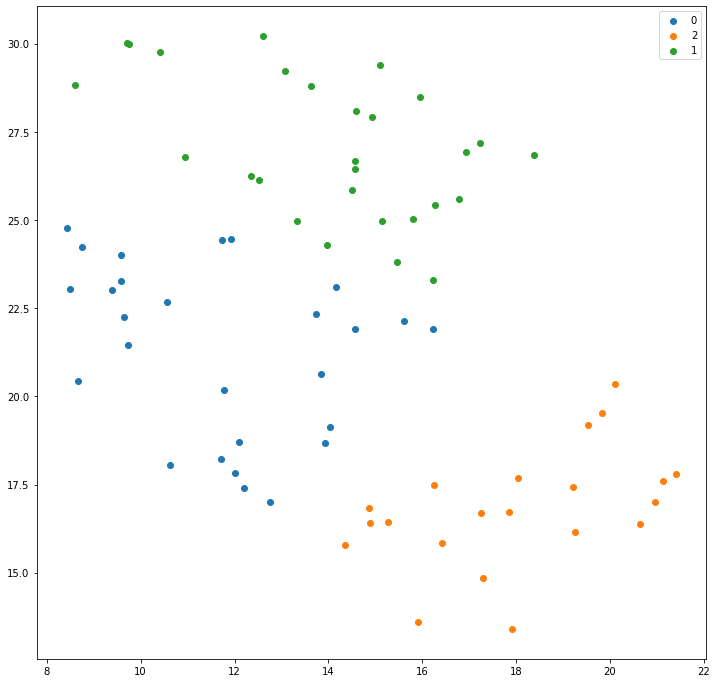

In [178]:
embeddings_df_3 = embeddings_df[embeddings_df["cluster_label"] == 4].copy()
clusters = KMeans(n_clusters=3, random_state=42)
clusters.fit(embeddings_df_3["pretrained_embeddings_2d"].to_list())
embeddings_df_3["cluster_label_st2"] = clusters.labels_

u_labels = embeddings_df_3["cluster_label_st2"].unique()
rgb_values = sns.color_palette("husl", 14)
for i in u_labels:
    plt.scatter(
        np.array(
            embeddings_df_3[embeddings_df_3["cluster_label_st2"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df_3[embeddings_df_3["cluster_label_st2"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
plt.legend()
plt.show()

Lost class recovered

In [179]:
embeddings_df_res = pd.concat(
    [embeddings_df, embeddings_df_3["cluster_label_st2"]], axis=1, join="outer"
)

embeddings_df_res.loc[embeddings_df_res["cluster_label"] == 6, "cluster_label"] = 5
embeddings_df_res.loc[embeddings_df_res["cluster_label"] == 2, "cluster_label"] = 1
embeddings_df_res.loc[embeddings_df_res["cluster_label"] == 8, "cluster_label"] = 1

embeddings_df_res.loc[embeddings_df_res["cluster_label_st2"] == 2, "cluster_label"] = 2
embeddings_df_res

,paths,pretrained_embeddings,imagenet_embeddings,pretrained_embeddings_norm,imagenet_embeddings_norm,pretrained_embeddings_2d,imagenet_embeddings_2d,gt_label,gt_labelnum,cluster_label,cluster_label_st2
0,/kaggle/input/bj-demo/images/Impressionism/pau...,"[0.2977924, 0.5097534, 1.0638214, 1.108568, 0....","[0.4522834, 0.56896514, 0.79019374, 0.38966966...","[0.012335483626230123, 0.021115564703671232, 0...","[0.024243567772852886, 0.030498011836693747, 0...","[-22.01985740661621, -19.81848907470703]","[23.26479148864746, 0.6043810844421387]",Impressionism,2,-1,NaN
1,/kaggle/input/bj-demo/images/Impressionism/pie...,"[0.45813334, 0.27153686, 0.069398075, 1.185244...","[1.0454112, 0.23239356, 0.15760773, 0.59222317...","[0.01628242091133669, 0.009650634459303182, 0....","[0.05309059235322746, 0.011801969946335217, 0....","[-13.922357559204102, -31.664817810058594]","[29.474905014038086, 26.379676818847656]",Impressionism,2,0,NaN
2,/kaggle/input/bj-demo/images/Impressionism/joa...,"[0.39953813, 0.21478486, 1.050751, 0.4029701, ...","[0.54769623, 0.49007434, 0.8008321, 0.26858845...","[0.01537437481955783, 0.00826500078019854, 0.0...","[0.026664635031415213, 0.02385930838906631, 0....","[-18.973257064819336, -12.948076248168945]","[21.522924423217773, 16.81128692626953]",Impressionism,2,0,NaN
3,/kaggle/input/bj-demo/images/Impressionism/pau...,"[0.28563625, 0.22489244, 0.41205797, 0.5561690...","[0.580393, 0.28342146, 0.12729098, 0.58343625,...","[0.014028362670027187, 0.01104507119222684, 0....","[0.03637330635799881, 0.017762059823113654, 0....","[-24.72813606262207, 1.5548288822174072]","[10.821257591247559, -12.289535522460938]",Impressionism,2,1,NaN
4,/kaggle/input/bj-demo/images/Impressionism/dav...,"[0.019111684, 0.31537342, 0.4833817, 0.6695326...","[0.086464666, 0.6419951, 0.26506567, 0.1341252...","[0.0007059421815571688, 0.011649177821036586, ...","[0.004603487300347879, 0.03418062319610865, 0....","[-21.42441749572754, -26.523723602294922]","[28.42928695678711, 16.114620208740234]",Impressionism,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1417,/kaggle/input/bj-demo/images/photo/004430.jpg,"[0.699724, 0.3162339, 0.8248184, 1.2662191, 1....","[0.47241056, 0.9193881, 0.7051153, 0.96716833,...","[0.029229918648254975, 0.013210195760193255, 0...","[0.023682542123399392, 0.04609009541783431, 0....","[35.04843521118164, -1.2023907899856567]","[8.677168846130371, 18.737401962280273]",photo,7,9,NaN
1418,/kaggle/input/bj-demo/images/photo/005873.jpg,"[0.8324461, 1.6524138, 0.4383622, 0.36241364, ...","[0.33142737, 0.9900289, 0.31255385, 0.5139535,...","[0.03776769658924401, 0.07496925610625502, 0.0...","[0.01948301323185764, 0.05819901586491329, 0.0...","[36.22367858886719, -5.466565132141113]","[14.331660270690918, -0.6798086762428284]",photo,7,9,NaN
1419,/kaggle/input/bj-demo/images/photo/001847.jpg,"[1.2205918, 1.5042881, 0.60274136, 0.6453149, ...","[0.551329, 0.85138214, 0.8390391, 0.6017941, 0...","[0.04866927201158261, 0.05998123746925116, 0.0...","[0.03047108206808304, 0.047054543045509475, 0....","[44.074623107910156, 1.8003557920455933]","[15.711372375488281, 28.62557029724121]",photo,7,9,NaN
1420,/kaggle/input/bj-demo/images/photo/007104.jpg,"[1.2019722, 1.2645326, 0.5847196, 1.3119702, 0...","[0.98948133, 0.72828597, 0.32434756, 2.4290836...","[0.04930645081560237, 0.05187275577481571, 0.0...","[0.054707641263673126, 0.04026635600555507, 0....","[30.6473388671875, -1.5839619636535645]","[-27.894893646240234, -31.133974075317383]",photo,7,9,NaN


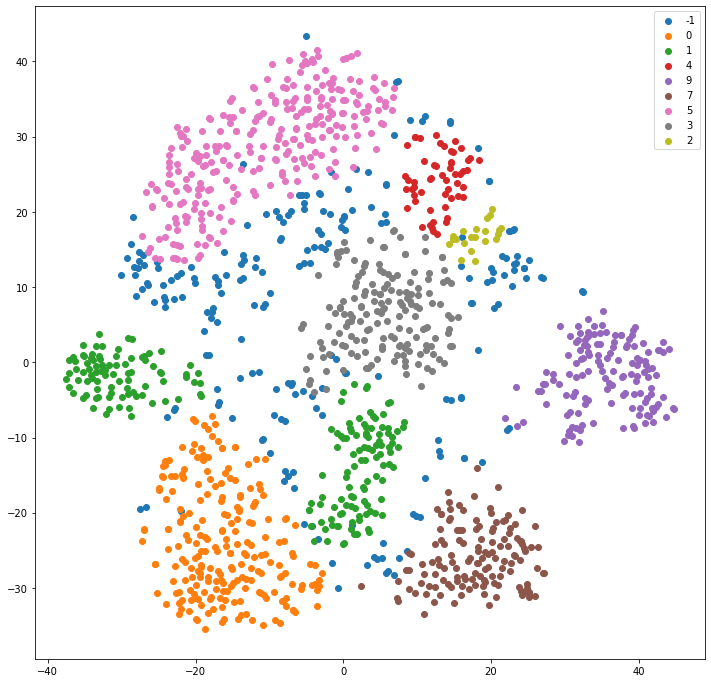

In [180]:
u_labels = embeddings_df_res["cluster_label"].unique()
for i in u_labels:
    plt.scatter(
        np.array(
            embeddings_df_res[embeddings_df_res["cluster_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df_res[embeddings_df_res["cluster_label"] == i][
                "pretrained_embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
plt.legend()
plt.show()

In [181]:
embeddings_df_res.to_excel("/kaggle/working/embeddings_df.xlsx")

# Task 3

Here we try to perform classification with gradient boosting.

In [182]:
test_files = glob.glob("/kaggle/temp/test/*/*.jpg")
val_files = glob.glob("/kaggle/temp/val/*/*.jpg")
train_files = glob.glob("/kaggle/temp/train/*/*.jpg")
train_files.extend(val_files)

train_files = ["/".join(x.split("/")[4:]) for x in train_files]
test_files = ["/".join(x.split("/")[4:]) for x in test_files]

In [183]:
def process_path(in_path):
    new_path = "/".join(in_path.split("/")[5:])
    return new_path
embeddings_df_res["paths2"] = embeddings_df_res["paths"].apply(process_path)

In [184]:
test_split = embeddings_df_res[embeddings_df_res["paths2"].isin(test_files)]
train_split = embeddings_df_res[embeddings_df_res["paths2"].isin(train_files)]
train_split_no_outliers = train_split[train_split["cluster_label"] != -1]

In [195]:
# original embeddings
X_train = train_split["pretrained_embeddings"].tolist()
X_test = test_split["pretrained_embeddings"].tolist()

# normalized embeddings
X_train_norm = train_split["pretrained_embeddings_norm"].tolist()
X_test_norm = test_split["pretrained_embeddings_norm"].tolist()

# normalized embeddings with outliers removed
X_train_no_outliers_norm = train_split_no_outliers["pretrained_embeddings_norm"].tolist()

# labels
y_train = train_split["gt_labelnum"].tolist()
y_test = test_split["gt_labelnum"].tolist()
y_train_no_outliers = train_split_no_outliers["gt_labelnum"].tolist()

In [196]:
xgb_classifier = xgboost.XGBClassifier(n_estimators=8)
xgb_classifier_norm = xgboost.XGBClassifier(n_estimators=8)
xgb_classifier_no_outliers_norm = xgboost.XGBClassifier(n_estimators=8)

In [197]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

sample_weights_no_outliers = compute_sample_weight(
    class_weight="balanced", y=y_train_no_outliers
)

xgb_classifier.fit(X_train, y_train, sample_weight=sample_weights)
xgb_classifier_norm.fit(X_train_norm, y_train, sample_weight=sample_weights)
xgb_classifier_no_outliers_norm.fit(
    X_train_no_outliers_norm, y_train_no_outliers, sample_weight=sample_weights_no_outliers
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=8, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [201]:
y_pred = xgb_classifier.predict(X_test)
y_pred_norm = xgb_classifier_norm.predict(X_test_norm)
y_pred_no_outliers = xgb_classifier_no_outliers_norm.predict(X_test_norm)

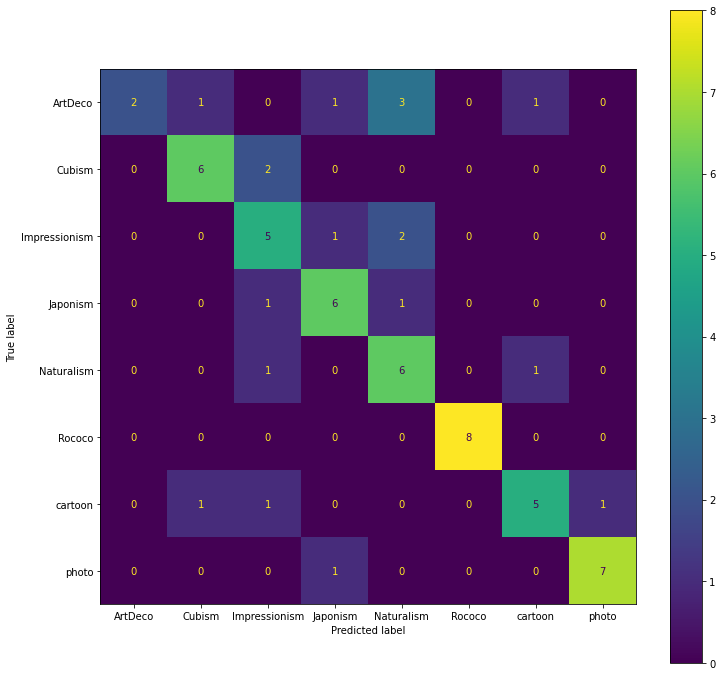

               precision    recall  f1-score   support

      ArtDeco       1.00      0.25      0.40         8
       Cubism       0.75      0.75      0.75         8
Impressionism       0.50      0.62      0.56         8
     Japonism       0.67      0.75      0.71         8
   Naturalism       0.50      0.75      0.60         8
       Rococo       1.00      1.00      1.00         8
      cartoon       0.71      0.62      0.67         8
        photo       0.88      0.88      0.88         8

     accuracy                           0.70        64
    macro avg       0.75      0.70      0.69        64
 weighted avg       0.75      0.70      0.69        64



In [203]:
# Original embeddings, with outliers
get_accuracy(y_test, y_pred)

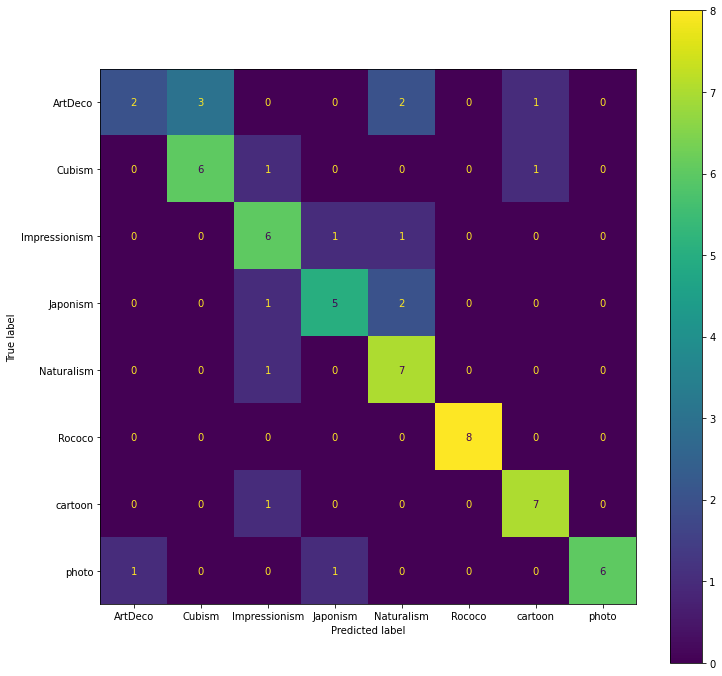

               precision    recall  f1-score   support

      ArtDeco       0.67      0.25      0.36         8
       Cubism       0.67      0.75      0.71         8
Impressionism       0.60      0.75      0.67         8
     Japonism       0.71      0.62      0.67         8
   Naturalism       0.58      0.88      0.70         8
       Rococo       1.00      1.00      1.00         8
      cartoon       0.78      0.88      0.82         8
        photo       1.00      0.75      0.86         8

     accuracy                           0.73        64
    macro avg       0.75      0.73      0.72        64
 weighted avg       0.75      0.73      0.72        64



In [204]:
# Normalized, with outliers
get_accuracy(y_test, y_pred_norm)

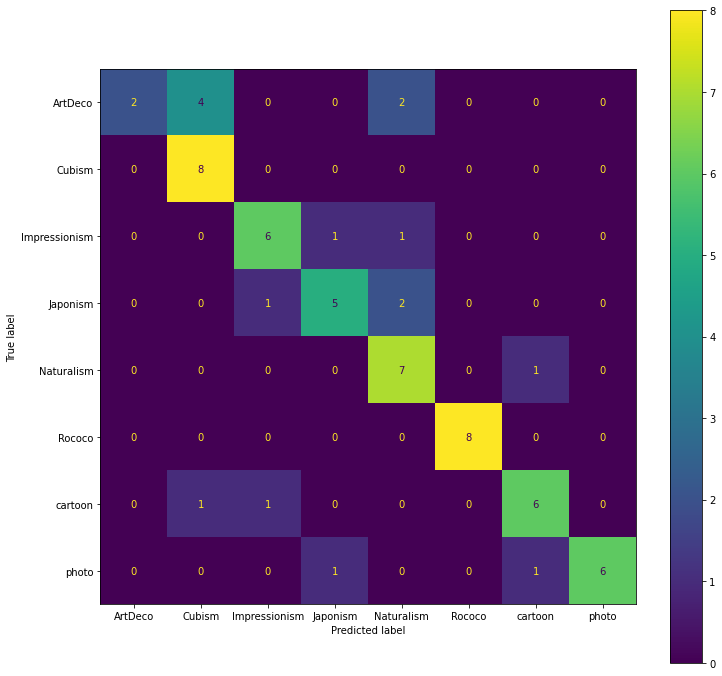

               precision    recall  f1-score   support

      ArtDeco       1.00      0.25      0.40         8
       Cubism       0.62      1.00      0.76         8
Impressionism       0.75      0.75      0.75         8
     Japonism       0.71      0.62      0.67         8
   Naturalism       0.58      0.88      0.70         8
       Rococo       1.00      1.00      1.00         8
      cartoon       0.75      0.75      0.75         8
        photo       1.00      0.75      0.86         8

     accuracy                           0.75        64
    macro avg       0.80      0.75      0.74        64
 weighted avg       0.80      0.75      0.74        64



In [205]:
# Normalized, without outliers
get_accuracy(y_test, y_pred_no_outliers)

Removing outliers and normalizing significantly improved overall quality (70% vs 75% accuracy)

## Feature engineering

It is better to perform feature engineering first because by reducing features we improve the overall computation speed

In [207]:
thresholds = np.sort(xgb_classifier_no_outliers_norm.feature_importances_)
thresholds = thresholds[thresholds > 0]
accuracies = []
nfeats = []

for thresh in tqdm.tqdm(thresholds):

    # select features using threshold
    selection = SelectFromModel(xgb_classifier_no_outliers_norm, 
                                threshold=thresh, 
                                prefit=True)
    select_X_train = selection.transform(X_train)

    # train model
    selection_model = xgboost.XGBClassifier(n_jobs=2)
    selection_model.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]

    # log accuracy
    accuracies.append(accuracy_score(y_test, predictions))
    nfeats.append(select_X_train.shape[1])
accuracies = np.array(accuracies)

100%|██████████| 382/382 [1:08:45<00:00, 10.80s/it]


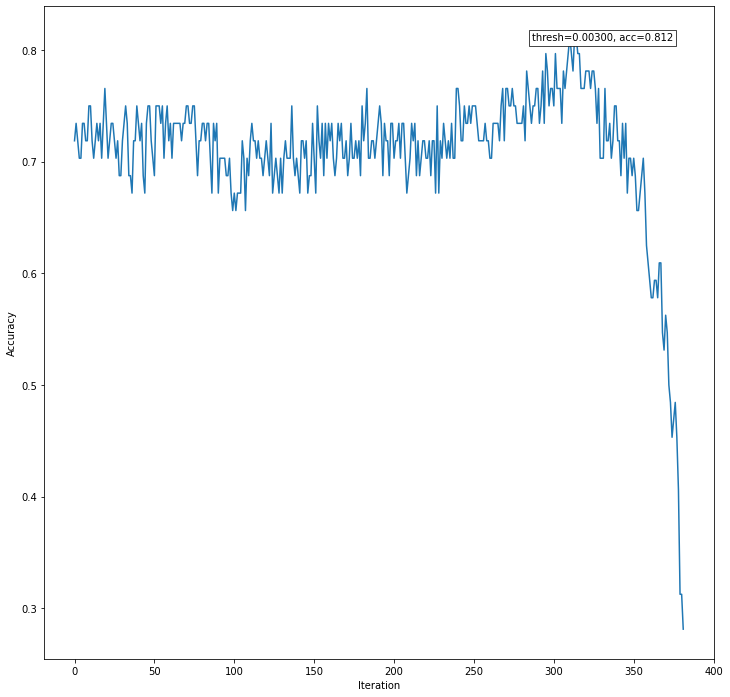

In [208]:
# x axis is the number of iterations
x_axis = np.linspace(0, len(accuracies) - 1, len(accuracies))


def annot_max(x, y, ax=None):
    """point the maximum"""
    xmax = int(x[np.argmax(y)])
    thresh = thresholds[xmax]
    ymax = y.max()
    text = "thresh={:.5f}, acc={:.3f}".format(thresh, ymax)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(
        xycoords="data",
        textcoords="axes fraction",
        arrowprops=arrowprops,
        bbox=bbox_props,
        ha="right",
        va="top",
    )
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94, 0.96), **kw)


fig, ax = plt.subplots()
ax.plot(x_axis, np.array(accuracies))
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
annot_max(x_axis, np.array(accuracies))

There are multiple maxima. For better performance lets choose the one last one.

In [209]:
# np argmax gives the first
# best_thresh = thresholds[np.argmax(accuracies)]

# the last occurence
best_thresh = thresholds[len(accuracies[::-1]) - np.argmax(accuracies[::-1]) - 1]

selection = SelectFromModel(xgb_classifier_no_outliers_norm, 
                            threshold=best_thresh, 
                            prefit=True)
select_X_train = selection.transform(X_train)
selection_model = xgboost.XGBClassifier()
selection_model.fit(select_X_train, y_train)
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

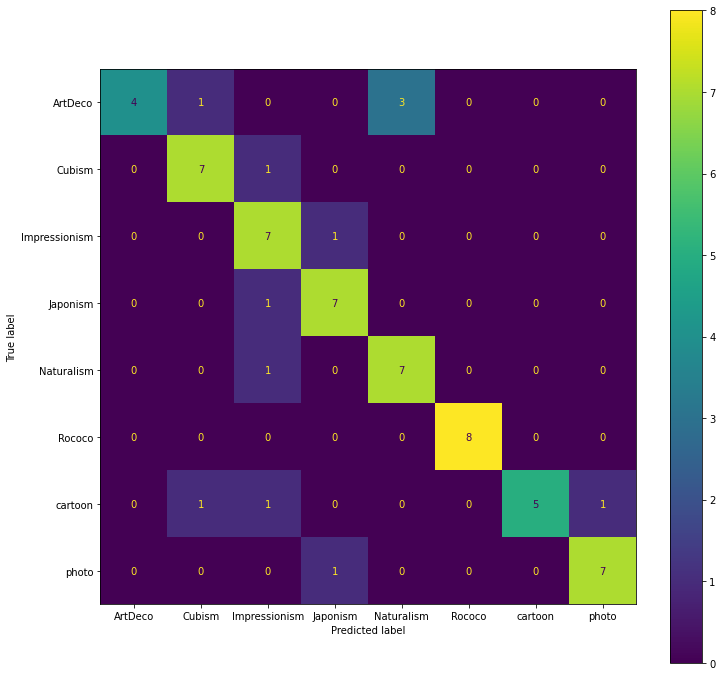

               precision    recall  f1-score   support

      ArtDeco       1.00      0.50      0.67         8
       Cubism       0.78      0.88      0.82         8
Impressionism       0.64      0.88      0.74         8
     Japonism       0.78      0.88      0.82         8
   Naturalism       0.70      0.88      0.78         8
       Rococo       1.00      1.00      1.00         8
      cartoon       1.00      0.62      0.77         8
        photo       0.88      0.88      0.88         8

     accuracy                           0.81        64
    macro avg       0.85      0.81      0.81        64
 weighted avg       0.85      0.81      0.81        64



In [210]:
get_accuracy(y_test, y_pred)

The result accuracy increase is about 6%

## Hyperparameter optimization

In [228]:
# Initialize domain space for range of values
# we will not use gblinear because these are generally outperformed by decision trees
booster_types = ["gbtree", "dart"]
space = {
    "booster": hp.choice("booster", booster_types),
    "learning_rate": hp.uniform("learning_rate", 0.1, 0.6),
    "n_estimators": hp.quniform("n_estimators", 80, 120, 1),
    "seed": 42,
}

In [229]:
# Define objective function
def objective(space):

    clf = xgboost.XGBClassifier(
        booster=space["booster"],
        learning_rate=space["learning_rate"],
        n_estimators=int(space["n_estimators"]),
        n_jobs=2,
    )

    evaluation = [(select_X_train, y_train), (select_X_test, y_test)]

    clf.fit(select_X_train, y_train, eval_set=evaluation, verbose=False)

    pred = clf.predict(select_X_test)
    accuracy = accuracy_score(y_test, pred)
    return {"loss": -accuracy, "status": STATUS_OK}


In [230]:
# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

100%|██████████| 50/50 [23:29<00:00, 28.19s/trial, best loss: -0.828125]


In [231]:
# Optimization results
print("The best hyperparameters are : ", "\n")
print(best_hyperparams)

The best hyperparameters are :  

{'booster': 0, 'learning_rate': 0.31054881530023615, 'n_estimators': 88.0}


In [232]:
clf_best = xgboost.XGBClassifier(
    learning_rate=best_hyperparams["learning_rate"],
    n_estimators=int(best_hyperparams["n_estimators"]),
)

In [233]:
clf_best.fit(select_X_train, y_train)
y_pred = clf_best.predict(select_X_test)

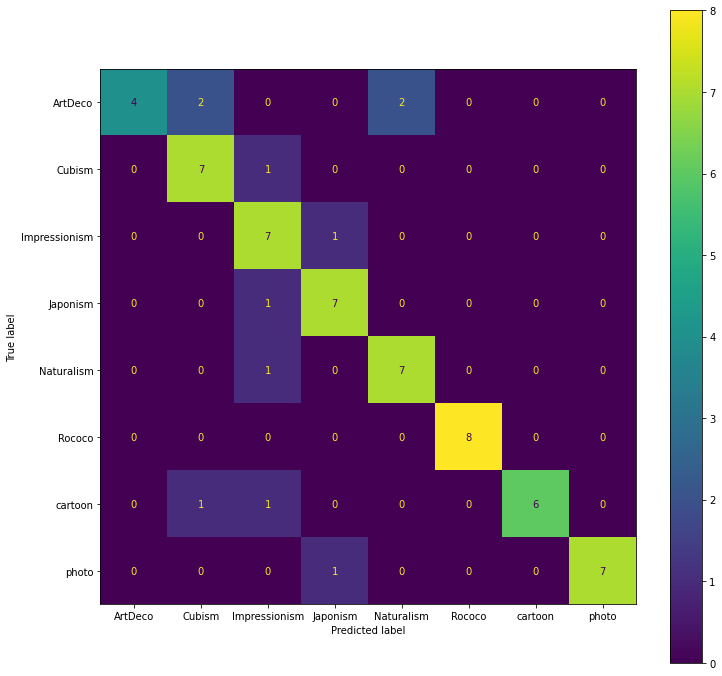

               precision    recall  f1-score   support

      ArtDeco       1.00      0.50      0.67         8
       Cubism       0.70      0.88      0.78         8
Impressionism       0.64      0.88      0.74         8
     Japonism       0.78      0.88      0.82         8
   Naturalism       0.78      0.88      0.82         8
       Rococo       1.00      1.00      1.00         8
      cartoon       1.00      0.75      0.86         8
        photo       1.00      0.88      0.93         8

     accuracy                           0.83        64
    macro avg       0.86      0.83      0.83        64
 weighted avg       0.86      0.83      0.83        64



In [234]:
get_accuracy(y_test, y_pred)

# Conclusion

The theory, presented in base article has been proved to work. The XGBoost algorithm on its own provides resuts quite close to the original CNN head. The outlier removal and feature selection have proved a significant improvement in the result. There is also a small increase in accuracy, provided both with hyperparameter tuning and normalization.

There are following ideas have been tested:

1) Try metric learning - Done, see bg-report-metric-learning.ipynb. The metric learning improves overall accuracy even more.

2) Generate synthetic data - deal with class imbalance and enlarge dataset size. Sources: [#1](https://towardsdatascience.com/how-to-make-artistic-images-with-neural-style-transfer-345a376d56cf) [#2](https://paperswithcode.com/task/style-transfer) - postponed due to complexity and time estimation.

3) Use clusterization to remove labeling outliers - Done, confirmed accuracy increase up to 5%

4) In task #1 use metrics with class weights (instead of oversampling) - Done, this method deals with overfitting better than the oversampling, although the validation accuracy is smaller.

5) Try more advanced clustering algorithms - Done, it is possible to clearly represent the original classes with noise removal. If there was no labeling, the problem could have been solved with semi-supervised learning.

6) Try more advanced gradient boosting algoruthms - Done, the XGBoost with feature selection is confirmed to increase the overall accuracy up to 12%, compared to original CNN.

7) Hyperparameter tuning (see main article) - Done, hyperparameter optimization is confirmed to increase the overall accyracy up to 1%

8) Try auto-sklearn (basically this is a combination of 6 and 7) - postponed, as the result is expected to be similar to the XGBoost algorithm.